Coefficient de corrélation entre GM et VLKAF: 0.8236757838744329
Backtest Statistics:
Mean Return (Stock): 0.0002
Mean Return (Strategy): 0.0049
Cumulative Return (Stock): -0.71%
Cumulative Return (Strategy): 15.95%
Variance (Stock): 0.0005
Variance (Strategy): 0.0005
Beta: 1.1835
Sharpe Ratio (Stock): -1.3899
Sharpe Ratio (Strategy): -1.0760
Maximum Drawdown: nan%


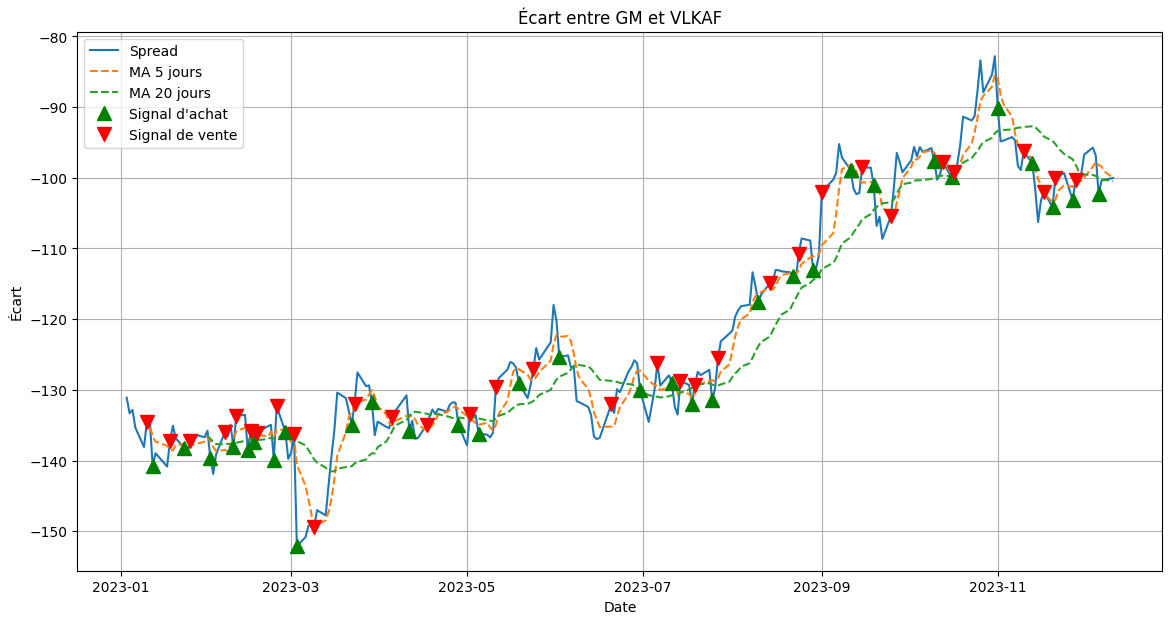

None
Merci d'avoir suivi nos services. Quitter le programme


In [12]:
# Résumé: cf ReadMe

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Choix du stock
possible_stocks = ["Google", "General Motors"]
stock=input("Choisissez quel actif vous souhaitez tester entre Google et General Motors")
while stock not in possible_stocks:
    stock = input("Please choose from Google and General Motors: ")


# Choix du degré de risque de l'investissement
risk=input("Souhaitez-vous prendre une position risquée ( yes/no)?")
while risk not in ["yes", "no"]:
    risk = input("Please respond with yes or no: ")


# Choix d'investir à court ou long terme
rend=input("Préférez-vous obtenir un rendement important à court terme (1 year) ou long terme ? ( 10 years)")
while rend not in ["short term", "long term"]:
    rend = input("Please respond with short term or long term: ")


# Stratégie à retourner en fonction du type d'investissement choisi par l'utilisateur



def investment_choice(stock, risk, rend):
    
    # Stratégie 1
    if stock == "Google" and risk == "no":
        if rend == "long term":
            # Mise à jour des URL avec les chemins d’accès aux fichiers Raw
            # url_GOOGL_10years 
            url_GOOGL = 'https://raw.githubusercontent.com/Cosima2/Project-Python/main/GOOGL-10years.csv'
        else: 
            # url_GOOGL_1year
            url_GOOGL = 'https://raw.githubusercontent.com/Cosima2/Project-Python/main/GOOGL_1year.csv'
  
        # Lire les fichiers CSV
        data_GOOGL = pd.read_csv(url_GOOGL, parse_dates=['Date'], index_col='Date')

        # En supposant que « data » est l’un des jeux de données chargés, on le remplace par les données souhaitées pour l’analyse
        data = data_GOOGL

        # Calcul des bandes de Bollinger 
        window = 20
        data['Rolling Mean'] = data['Close'].rolling(window=window).mean()
        data['Upper Band'] = data['Rolling Mean'] + 2 * data['Close'].rolling(window=window).std()
        data['Lower Band'] = data['Rolling Mean'] - 2 * data['Close'].rolling(window=window).std()

        # Signaux d'achat et de vente en fonction des bandes de Bollinger
        # Signal d'achat si le prix de fermeture est inférieur à la bande inférieure
        data['Buy Signal'] = np.where(data['Close'] < data['Lower Band'].shift(1), 1, 0)
        # Signal de vente si le prix de fermeture est supérieur à la valeur de la bande supérieure
        data['Sell Signal'] = np.where(data['Close'] > data['Upper Band'].shift(1), 1, 0)

        # Analyse volumique
        volume_window = 5
        data['Volume MA'] = data['Volume'].rolling(window=volume_window).mean()
        # Filtrage des données pour les signaux d’achat
        buy_signals_data = data[data['Buy Signal'] == 1]

        # Vérification de la génération des signaux d’achat 
        if not buy_signals_data.empty:
            # Calcul de rendement cumulatif
            cumulative_return_strategy = (1 + buy_signals_data['Close'].pct_change()).cumprod().iloc[-1] - 1
        else:
            print("No Buy Signals generated.")
    
        # Filtrage des signaux d’achat et de vente en fonction du volume
        data['Buy Signal'] = np.where((data['Buy Signal'] == 1) & (data['Volume'] > data['Volume MA']), 1, 0)
        data['Sell Signal'] = np.where((data['Sell Signal'] == 1) & (data['Volume'] > data['Volume MA']), 1, 0)

        # Calcul de rendement cumulatif
        cumulative_return_strategy = (1 + data[data['Buy Signal'] == 1]['Close'].pct_change()).cumprod().iloc[-1] - 1
        cumulative_return_stock = (1 + data['Close'].pct_change()).cumprod().iloc[-1] - 1

        # Calcul du Sharpe Ratio
        daily_returns_strategy = data[data['Buy Signal'] == 1]['Close'].pct_change()
        daily_returns_stock = data['Close'].pct_change()

        sharpe_ratio_strategy = (daily_returns_strategy.mean() / daily_returns_strategy.std()) * np.sqrt(252)
        sharpe_ratio_stock = (daily_returns_stock.mean() / daily_returns_stock.std()) * np.sqrt(252)

        # Calcul du rendement moyen
        mean_return_strategy = daily_returns_strategy.mean()
        mean_return_stock = daily_returns_stock.mean()

        # Calcul de la variance
        variance_strategy = daily_returns_strategy.var()
        variance_stock = daily_returns_stock.var()

        # Filtrage pour supprimer les parties sans valeurs et alignement
        valid_dates = daily_returns_strategy.index.intersection(daily_returns_stock.index)
        daily_returns_strategy_aligned = daily_returns_strategy.loc[valid_dates]
        daily_returns_stock_aligned = daily_returns_stock.loc[valid_dates]

        # Calcul de la covariance
        covariance = np.cov(daily_returns_strategy_aligned, daily_returns_stock_aligned)[0, 1]

        # Calcul du bêta
        beta = covariance / variance_stock

        # Calcul du bêta dans les tendances haussières et baissières
        uptrend_indices = daily_returns_strategy[daily_returns_strategy > 0].index
        downtrend_indices = daily_returns_strategy[daily_returns_strategy <= 0].index

        uptrend_returns_strategy = daily_returns_strategy[daily_returns_strategy.index.isin(uptrend_indices)]
        downtrend_returns_strategy = daily_returns_strategy[daily_returns_strategy.index.isin(downtrend_indices)]

        uptrend_returns_stock = daily_returns_stock[daily_returns_stock.index.isin(uptrend_indices)]
        downtrend_returns_stock = daily_returns_stock[daily_returns_stock.index.isin(downtrend_indices)]

        beta_up = np.cov(uptrend_returns_strategy, uptrend_returns_stock)[0, 1] / np.var(uptrend_returns_strategy)
        beta_down = np.cov(downtrend_returns_strategy, downtrend_returns_stock)[0, 1] / np.var(downtrend_returns_strategy)

        # Affichage des statistiques du backtest
        print("Backtest Statistics:")
        print(f"Mean Return (Stock): {mean_return_stock:.4f}")
        print(f"Mean Return (Strategy): {mean_return_strategy:.4f}")
        print(f"Cumulative Return (Stock): {cumulative_return_stock * 100:.2f}%")
        print(f"Cumulative Return (Strategy): {cumulative_return_strategy * 100:.2f}%")
        print(f"Variance (Stock): {variance_stock:.4f}")
        print(f"Variance (Strategy): {variance_strategy:.4f}")
        print(f"Beta: {beta:.4f}")
        print(f"Beta in Uptrends: {beta_up:.4f}")
        print(f"Beta in Downtrends: {beta_down:.4f}")
        print(f"Sharpe Ratio (Stock): {sharpe_ratio_stock:.4f}")
        print(f"Sharpe Ratio (Strategy): {sharpe_ratio_strategy:.4f}")
        # Tracé
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

        # Tracé du cours de l’action et les bandes de Bollinger
        ax1.plot(data['Close'], label='Close Price', linewidth=2, color='b')
        ax1.plot(data['Rolling Mean'], label=f'{window}-Day Rolling Mean', linestyle='--', linewidth=2, color='g')
        ax1.plot(data['Upper Band'], label='Upper Bollinger Band', linestyle='--', linewidth=2, color='r')
        ax1.plot(data['Lower Band'], label='Lower Bollinger Band', linestyle='--', linewidth=2, color='r')

        # Tracé des signaux d’achat
        ax1.plot(data[data['Buy Signal'] == 1].index, data['Close'][data['Buy Signal'] == 1], '^', markersize=10, color='g', label='Buy Signal')

        # Tracé des signaux de vente
        ax1.plot(data[data['Sell Signal'] == 1].index, data['Close'][data['Sell Signal'] == 1], 'v', markersize=10, color='r', label='Sell Signal')
        ax1.set_ylabel('Stock Price')
        ax1.legend(loc='upper left')
        ax1.set_title('Stock Price with Bollinger Bands and Volume Analysis Buy/Sell Signals')

       # Volume du graphique et moyenne mobile du volume
        ax2.bar(data.index, data['Volume'], color='gray', alpha=0.7, label='Volume')
        ax2.plot(data['Volume MA'], label=f'{volume_window}-Day Volume MA', color='orange', linestyle='--', linewidth=2)
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Volume')
        ax2.legend(loc='upper left')

        plt.tight_layout()
        plt.show()


# Stratégie 2
    # Si l'utilisateur a choisi le stock General Motors et un investissement à long terme pas risqué
    elif stock == "General Motors" and risk == "no" and rend == "long term":
        # Mise à jour des URL avec les chemins d’accès aux fichiers Raw
        # url_GM_10years
        url_GM = 'https://raw.githubusercontent.com/Cosima2/Project-Python/main/GM_10years.csv'
        
        # Lecture les fichiers CSV
        data_GM = pd.read_csv(url_GM, parse_dates=['Date'], index_col='Date')

        # En supposant que 'data' est l’un des jeux de données chargés, on le remplace par les données souhaitées pour l’analyse
        data = data_GM
        
        # Calcul de la moyenne mobile sur 14 jours
        data['SMA_14'] = data['Close'].rolling(window=14).mean()

        # Création d'une colonne pour stocker les signaux d'achat et de vente
        data['Signal'] = 0  # 0: Pas de signal, 1: Signal d'achat, -1: Signal de vente

        # Génération des signaux d'achat et de vente en fonction des croisements de la moyenne mobile
        for i in range(14, len(data)):
            if data['Close'][i] > data['SMA_14'][i]:
                data['Signal'][i] = 1
            elif data['Close'][i] < data['SMA_14'][i]:
                data['Signal'][i] = -1

        # Calcul des rendements
        data['Stock_Return'] = np.log(data['Close'] / data['Close'].shift(1))
        data['Strategy_Return'] = data['Signal'].shift(1) * data['Stock_Return']

        # Calcul des rendements cumulés
        data['Stock_Cumulative_Return'] = data['Stock_Return'].cumsum()
        data['Strategy_Cumulative_Return'] = data['Strategy_Return'].cumsum()

        # Calcul des statistiques
        mean_return_stock = data['Stock_Return'].mean()
        mean_return_strategy = data['Strategy_Return'].mean()
        cumulative_return_stock = data['Stock_Cumulative_Return'].iloc[-1]
        cumulative_return_strategy = data['Strategy_Cumulative_Return'].iloc[-1]
        variance_stock = data['Stock_Return'].var()
        variance_strategy = data['Strategy_Return'].var()
        beta = data['Strategy_Return'].cov(data['Stock_Return']) / data['Stock_Return'].var()
        sharpe_ratio_stock = (mean_return_stock - 0.02) / np.sqrt(variance_stock)  # Supposons que le taux sans risque soit de 0.02
        sharpe_ratio_strategy = (mean_return_strategy - 0.02) / np.sqrt(variance_strategy)  # Supposons que le taux sans risque soit de 0.02
        max_drawdown = (data['Stock_Cumulative_Return'] / data['Stock_Cumulative_Return'].cummax() - 1).min()

        # Affichage des statistiques
        print("Backtest Statistics:")
        print(f"Mean Return (Stock): {mean_return_stock:.4f}")
        print(f"Mean Return (Strategy): {mean_return_strategy:.4f}")
        print(f"Cumulative Return (Stock): {cumulative_return_stock * 100:.2f}%")
        print(f"Cumulative Return (Strategy): {cumulative_return_strategy * 100:.2f}%")
        print(f"Variance (Stock): {variance_stock:.4f}")
        print(f"Variance (Strategy): {variance_strategy:.4f}")
        print(f"Beta: {beta:.4f}")
        print(f"Sharpe Ratio (Stock): {sharpe_ratio_stock:.4f}")
        print(f"Sharpe Ratio (Strategy): {sharpe_ratio_strategy:.4f}")
        print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

        # Graphique des signaux d'achat et de vente
        plt.figure(figsize=(12, 6))
        plt.plot(data['Close'], label='Close Price')
        plt.plot(data[data['Signal'] == 1].index, data['Close'][data['Signal'] == 1], marker='^', markersize=10, color='g', lw=0, label='Buy Signal')
        plt.plot(data[data['Signal'] == -1].index, data['Close'][data['Signal'] == -1], marker='v', markersize=10, color='r', lw=0, label='Sell Signal')
        plt.title('Buy and Sell Signals')
        plt.legend()
        plt.show()

    # Si l'utilisateur choix le stock General Motors et un investissement non risqué à court terme
    elif stock == "General Motors" and risk == "no" and rend == "short term":

        # Mise à jour des URL avec les chemins d’accès aux fichiers Raw
        url_GM_1year = 'https://raw.githubusercontent.com/Cosima2/Project-Python/main/GM_1year.csv'

        # Lecture du fichier CSV 
        data_GM_1year = pd.read_csv(url_GM_1year, parse_dates=['Date'], index_col='Date')

        # En supposant que 'data' est l’un des jeux de données chargés, on le remplace par les données souhaitées pour l’analyse
        data = data_GM_1year

        # Calcul de la moyenne mobile sur 14 jours
        data['SMA_14'] = data['Close'].rolling(window=14).mean()

        # Création d'une colonne pour stocker les signaux d'achat et de vente
        data['Signal'] = 0  # 0: Pas de signal, 1: Signal d'achat, -1: Signal de vente

        # Génération des signaux d'achat et de vente en fonction des croisements de la moyenne mobile
        for i in range(14, len(data)):
            if data['Close'][i] > data['SMA_14'][i]:
                data['Signal'][i] = 1
            elif data['Close'][i] < data['SMA_14'][i]:
                data['Signal'][i] = -1

        # Calcul des rendements
        data['Stock_Return'] = np.log(data['Close'] / data['Close'].shift(1))
        data['Strategy_Return'] = data['Signal'].shift(1) * data['Stock_Return']

        # Calcul des rendements cumulés
        data['Stock_Cumulative_Return'] = data['Stock_Return'].cumsum()
        data['Strategy_Cumulative_Return'] = data['Strategy_Return'].cumsum()

        # Calcul des statistiques
        mean_return_stock = data['Stock_Return'].mean()
        mean_return_strategy = data['Strategy_Return'].mean()
        cumulative_return_stock = data['Stock_Cumulative_Return'].iloc[-1]
        cumulative_return_strategy = data['Strategy_Cumulative_Return'].iloc[-1]
        variance_stock = data['Stock_Return'].var()
        variance_strategy = data['Strategy_Return'].var()
        beta = data['Strategy_Return'].cov(data['Stock_Return']) / data['Stock_Return'].var()
        sharpe_ratio_stock = (mean_return_stock - 0.02) / np.sqrt(variance_stock)  # Supposons que le taux sans risque soit de 0.02
        sharpe_ratio_strategy = (mean_return_strategy - 0.02) / np.sqrt(variance_strategy)  # Supposons que le taux sans risque soit de 0.02
        max_drawdown = (data['Stock_Cumulative_Return'] / data['Stock_Cumulative_Return'].cummax() - 1).min()

        # Affichage des statistiques
        print("Backtest Statistics:")
        print(f"Mean Return (Stock): {mean_return_stock:.4f}")
        print(f"Mean Return (Strategy): {mean_return_strategy:.4f}")
        print(f"Cumulative Return (Stock): {cumulative_return_stock * 100:.2f}%")
        print(f"Cumulative Return (Strategy): {cumulative_return_strategy * 100:.2f}%")
        print(f"Variance (Stock): {variance_stock:.4f}")
        print(f"Variance (Strategy): {variance_strategy:.4f}")
        print(f"Beta: {beta:.4f}")
        print(f"Sharpe Ratio (Stock): {sharpe_ratio_stock:.4f}")
        print(f"Sharpe Ratio (Strategy): {sharpe_ratio_strategy:.4f}")
        print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

        # Graphique des signaux d'achat et de vente
        plt.figure(figsize=(12, 6))
        plt.plot(data['Close'], label='Close Price')
        plt.plot(data[data['Signal'] == 1].index, data['Close'][data['Signal'] == 1], marker='^', markersize=10, color='g', lw=0, label='Buy Signal')
        plt.plot(data[data['Signal'] == -1].index, data['Close'][data['Signal'] == -1], marker='v', markersize=10, color='r', lw=0, label='Sell Signal')
        plt.title('Buy and Sell Signals')
        plt.legend()
        plt.show()

    # Stratégie 3
    # Si l'utilisateur a choisi le stock General Motors et risqué et un investissement à court terme  ou long terme
    elif stock == "General Motors" and risk == "yes": 
        # Mise à jour des URL avec les chemins d’accès aux fichiers Raw
        if rend == "short term":
            url_GM = 'https://raw.githubusercontent.com/Cosima2/Project-Python/main/GM_1year.csv'
            url_VLKAF = 'https://raw.githubusercontent.com/Cosima2/Project-Python/main/VLKAF_1year.csv'
        else:
            url_GM = 'https://raw.githubusercontent.com/Cosima2/Project-Python/main/GM_10years.csv'
            url_VLKAF = 'https://raw.githubusercontent.com/Cosima2/Project-Python/main/VLKAF_10years.csv'

        
       
        # Lecture des fichiers CSV
        symbol_GM = 'GM'
        symbol_VLKAF = 'VLKAF'
        data_GM = pd.read_csv(url_GM, parse_dates=['Date'], index_col='Date')
        data_VLKAF = pd.read_csv(url_VLKAF, parse_dates=['Date'], index_col='Date')

        # Extraction des prix de clôture ('Close')
        gm_close = data_GM['Close']
        volks_close = data_VLKAF['Close']

        # Fusion des données dans un DataFrame unique
        merged_data = pd.concat([gm_close, volks_close], axis=1)
        merged_data.columns = ['Close_GM', 'Close_VLKAF']

        # Calcul du coefficient de corrélation
        correlation_coefficient = merged_data['Close_GM'].corr(merged_data['Close_VLKAF'])
        print("Coefficient de corrélation entre GM et VLKAF:", correlation_coefficient)

        # Calcul de l'écart entre les prix des deux actions
        spread = merged_data['Close_GM'] - merged_data['Close_VLKAF']

        # Calcul des moyennes mobiles
        spread_ma5 = spread.rolling(window=5).mean()
        spread_ma20 = spread.rolling(window=20).mean()

        # Génération des signaux d'achat et de vente basés sur le croisement des moyennes mobiles
        merged_data['Buy Signal'] = (spread < spread_ma5) & (spread.shift(1) > spread_ma5.shift(1))
        merged_data['Sell Signal'] = (spread > spread_ma5) & (spread.shift(1) < spread_ma5.shift(1))

        # Calcul du rendement quotidien pour l'action et la stratégie
        daily_returns_stock = merged_data['Close_GM'].pct_change()
        daily_returns_strategy = daily_returns_stock[merged_data['Buy Signal'] == True]

        # Calcul du rendement moyen
        mean_return_stock = daily_returns_stock.mean()
        mean_return_strategy = daily_returns_strategy.mean()

        # Calcul du rendement cumulatif
        cumulative_return_stock = (1 + daily_returns_stock).cumprod() - 1
        cumulative_return_strategy = (1 + daily_returns_strategy).cumprod() - 1

        # Calcul de la variance
        variance_stock = daily_returns_stock.var()
        variance_strategy = daily_returns_strategy.var()

        # Calcul du bêta
        covariance = daily_returns_stock.cov(daily_returns_strategy)
        variance_market = daily_returns_stock.var()
        beta = covariance / variance_market

        # Calcul du ratio de Sharpe
        risk_free_rate = 0.03  # Taux sans risque arbitraire
        sharpe_ratio_stock = (mean_return_stock - risk_free_rate) / np.sqrt(variance_stock)
        sharpe_ratio_strategy = (mean_return_strategy - risk_free_rate) / np.sqrt(variance_strategy)

        # Calcul du maximum drawdown
        cumulative_values_stock = (1 + daily_returns_stock).cumprod()
        running_max = np.maximum.accumulate(cumulative_values_stock)
        drawdown = (cumulative_values_stock) / running_max - 1
        max_drawdown = np.min(drawdown)

        # Affichage des statistiques
        print("Backtest Statistics:")
        print(f"Mean Return (Stock): {mean_return_stock:.4f}")
        print(f"Mean Return (Strategy): {mean_return_strategy:.4f}")
        print(f"Cumulative Return (Stock): {cumulative_return_stock.iloc[-1] * 100:.2f}%")
        print(f"Cumulative Return (Strategy): {cumulative_return_strategy.iloc[-1] * 100:.2f}%")
        print(f"Variance (Stock): {variance_stock:.4f}")
        print(f"Variance (Strategy): {variance_strategy:.4f}")
        print(f"Beta: {beta:.4f}")
        print(f"Sharpe Ratio (Stock): {sharpe_ratio_stock:.4f}")
        print(f"Sharpe Ratio (Strategy): {sharpe_ratio_strategy:.4f}")
        print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

        # Affichage
        plt.figure(figsize=(14, 7))

        # Affichage de l'écart et des moyennes mobiles
        plt.plot(spread, label='Spread')
        plt.plot(spread_ma5, label='MA 5 jours', linestyle='--')
        plt.plot(spread_ma20, label='MA 20 jours', linestyle='--')

        # Affichage des signaux d'achat et de vente
        plt.plot(merged_data[merged_data['Buy Signal']].index, spread[merged_data['Buy Signal']], '^', markersize=10, color='g', label='Signal d\'achat')
        plt.plot(merged_data[merged_data['Sell Signal']].index, spread[merged_data['Sell Signal']], 'v', markersize=10, color='r', label='Signal de vente')
        plt.title('Écart entre GM et VLKAF')
        plt.xlabel('Date')
        plt.ylabel('Écart')
        plt.legend()
        plt.grid(True)
        plt.show()

# Stratégie 4
    else: 
    # Si l'utilisateur a choisi le stock General Motors et un investissement à court terme et pas risqué ou le stock Google et un investissment risqué à court ou long terme
        global url_stock_4
        if stock == "Google" and risk == "yes":
            # Mise à jour des URL avec les chemins d’accès aux fichiers Raw
            if rend =="short term":
                url_stock_4 = 'https://raw.githubusercontent.com/Cosima2/Project-Python/main/GOOGL_1year.csv'
            else: 
                # url_GOOGL_10years
                url_stock_4= 'https://raw.githubusercontent.com/Cosima2/Project-Python/main/GOOGL-10years.csv'
        elif stock == "Motors" and risk == "no" and rend =="short term":
            # url_GM_1year 
            url_stock_4 = 'https://raw.githubusercontent.com/Cosima2/Project-Python/main/GM_1year.csv'

        # Lecture des fichiers CSV
        data_stock = pd.read_csv(url_stock_4, parse_dates=['Date'], index_col='Date')

        # Ingénierie des fonctionnalités
        data = data_stock.copy()  # Copie des données pour éviter la modification des données originales
        data['SMA_50'] = data['Close'].rolling(window=50).mean()  # 50-day Simple Moving Average
        data['SMA_200'] = data['Close'].rolling(window=200).mean()  # 200-day Simple Moving Average
        data['Daily_Return'] = data['Close'].pct_change()  # Daily return
        data.dropna(inplace=True)

        # Définition des caractéristiques et de la variable cible
        features = ['SMA_50', 'SMA_200', 'Daily_Return']
        target = 'Close'

        X = data[features]
        y = data[target]

        # Division des données en ensembles d’entraînement et de test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Entraînement du modèle de régression linéaire
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Prédictions
        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)

        # Évaluation les performances du modèle
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

        print(f"Train RMSE: {train_rmse}")
        print(f"Test RMSE: {test_rmse}")

        # Exemple de stratégie de trading basée sur le prix prédit par rapport au prix réel
        predicted_prices = model.predict(X)
        data['Predicted_Close'] = predicted_prices

        # Achat si le prix prévu > le prix actuel, vente si le prix prédit < le prix actuel
        data['Signal'] = np.where(data['Predicted_Close'] > data['Close'], 1, -1)

        # Calcul du rendement cumulatif
        cumulative_return_strategy = (1 + data[data['Signal'] == 1]['Close'].pct_change()).cumprod().iloc[-1] - 1
        cumulative_return_stock = (1 + data['Close'].pct_change()).cumprod().iloc[-1] - 1

        # Calcul du drawdown maximal
        def calc_drawdown(cum_rets):
            running_max = np.maximum.accumulate(cum_rets)
            running_max[running_max < 1] = 1
            drawdown = (cum_rets) / running_max - 1
            return drawdown

        cumulative_values = np.array(data['Close'])
        drawdown = calc_drawdown(cumulative_values)
        max_drawdown = np.min(drawdown)

        # Calcul du Sharpe Ratio
        daily_returns_strategy = data[data['Signal'] == 1]['Close'].pct_change()
        daily_returns_stock = data['Close'].pct_change()

        sharpe_ratio_strategy = (daily_returns_strategy.mean() / daily_returns_strategy.std()) * np.sqrt(252)
        sharpe_ratio_stock = (daily_returns_stock.mean() / daily_returns_stock.std()) * np.sqrt(252)

        # Calcul du rendement moyen
        mean_return_strategy = daily_returns_strategy.mean()
        mean_return_stock = daily_returns_stock.mean()

        # Calcul de la variance
        variance_strategy = daily_returns_strategy.var()
        variance_stock = daily_returns_stock.var()

        # Filtrage pour supprimer les parties sans valeurs et alignement
        valid_dates = daily_returns_strategy.index.intersection(daily_returns_stock.index)
        daily_returns_strategy_aligned = daily_returns_strategy.loc[valid_dates]
        daily_returns_stock_aligned = daily_returns_stock.loc[valid_dates]

        # Calcul de la covariance
        covariance = np.cov(daily_returns_strategy_aligned, daily_returns_stock_aligned)[0, 1]

        # Calcul du beta
        beta = covariance / variance_stock

        # Affichage des statistiques du backtest
        print("Backtest Statistics:")
        print(f"Mean Return (Stock): {mean_return_stock:.4f}")
        print(f"Mean Return (Strategy): {mean_return_strategy:.4f}")
        print(f"Cumulative Return (Stock): {cumulative_return_stock * 100:.2f}%")
        print(f"Cumulative Return (Strategy): {cumulative_return_strategy * 100:.2f}%")
        print(f"Variance (Stock): {variance_stock:.4f}")
        print(f"Variance (Strategy): {variance_strategy:.4f}")
        print(f"Beta: {beta:.4f}")
        print(f"Sharpe Ratio (Stock): {sharpe_ratio_stock:.4f}")
        print(f"Sharpe Ratio (Strategy): {sharpe_ratio_strategy:.4f}")
        print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

        # Tracé du cours de l’action avec des signaux d’achat/vente
        plt.figure(figsize=(10, 6))
        plt.plot(data.index, data['Close'], label='Close Price', color='blue')
        plt.scatter(data[data['Signal'] == 1].index, data['Close'][data['Signal'] == 1], marker='^', color='g', label='Buy Signal')
        plt.scatter(data[data['Signal'] == -1].index, data['Close'][data['Signal'] == -1], marker='v', color='r', label='Sell Signal')
        plt.title('Stock Close Price with Buy/Sell Signals')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.grid(True)
        plt.show()


# Impression des résultats
result = investment_choice(stock, risk, rend)
print(result)

# Test de satisfaction
message= input("Observez désormais imprimé les résultats du backtest ainsi qu'un graphique simplifié (ok)")

satisfied = input("Etes vous satiasfait du résulat? (yes/no) ")
while satisfied == "no":
    while satisfied not in ["yes", "no"]:
        satisfied = input("s'il vous plaît, répondez avec yes ou no: ")


    if satisfied == "no":
        # Test de satisfaction du choix du stock
        change_choice_stock = input("Voulez-vous changer de stock choisi? (yes/no). Votre choix précédent était " + str(stock))
        while change_choice_stock not in ["yes", "no"]:
            change_choice_stock = input("s'il vous plaît, répondez avec yes ou no ")
        if change_choice_stock == "yes":
            if stock == "Google":
                stock = "General Motors"
            else:
                stock = "Google"


        # Test de satisfaction du choix du risque
        change_risk = input("voulez-vous changer le degré de risque de votre investissement? (yes/no). Votre choix précédent était " + str(risk))
        while change_risk not in ["yes", "no"]:
            change_risk = input("s'il vous plaît, répondez avec yes ou no: ")
        if change_risk == "yes":
            if risk == "yes":
                risk = "no"
            else:
                risk = "yes"


        # Test de satisfaction du choix du terme de la rentabilité
        change_rend = input("Voulez-vous changer l'horizon de votre investissement? (yes/no). Votre choix précédent était " + str(rend))
        while change_rend not in ["yes", "no"]:
            change_rend = input("s'il vous plaît, répondez avec yes ou no: ")
        if change_rend == "yes":
            if rend == "short term":
                rend = "long term"
            else:
                rend = "short term"

        message= input("Observez désormais imprimé les résultats du backtest ainsi qu'un graphique simplifié (ok)")
        result = investment_choice(stock, risk, rend)
        print(result)
        satisfied = input("Etes vous satiasfait du résulat? (yes/no) ")
    
message=input("Merci d'avoir suivi nos services. Pour quitter le programme tapez ok")